### 지역별 공원 및 등록현황 관련 데이터 분석

- 가설: 지역에 공원이 많을수록 반려동물 등록건수가 많은가?

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import mysql.connector
import koreanize_matplotlib 
import json
from folium.plugins import MarkerCluster

%matplotlib inline

In [14]:
conn = mysql.connector.connect(
    host = "database-2.c3iym8yog7ht.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "pethub",
    password = "addinedu5",
    database = "pethub"
)

In [15]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, c.type, p.name, p.lat, p.lng
                from pet_infra p
                LEFT JOIN infra_category c ON p.category_id = c.id
                LEFT JOIN region_list l ON p.region_id = l.id
                WHERE c.type LIKE '%공원%';
                """)

result = cursor.fetchall()

infra_df = pd.DataFrame(result, columns=["region", "type", "name", "lat", "lng"])
infra_df.head()

,region,type,name,lat,lng
0,은평구,공원,은평구 반려견 놀이터,37.490620,126.919205
1,광진구,공원,어린이대공원,37.549362,127.081810
2,마포구,공원,월드컵공원 반려견놀이터,37.563873,126.893501
3,동작구,공원,보라매공원,37.492680,126.919136
4,서초구,공원,매헌시민의숲,37.470684,127.035599


In [16]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, p.breed, r.count
                from region_pet_regist r
                LEFT JOIN region_list l ON r.region_id = l.id
                LEFT JOIN pet_type p ON r.pet_type_id = p.id;
                """)

result = cursor.fetchall()

regist_df = pd.DataFrame(result, columns=["region", "breed", "pet_count"])
regist_df.head()

,region,breed,pet_count
0,종로구,골든 리트리버,156
1,종로구,그레이 하운드,5
2,종로구,달마시안,3
3,종로구,도베르만,21
4,종로구,라브라도 리트리버,136


In [25]:
park_count = infra_df[infra_df['type'] == '공원'].groupby('region').size().reset_index(name='park_count')
pet_count = regist_df.groupby('region')['pet_count'].sum().reset_index()

merged_data = pd.merge(park_count, pet_count, on='region', how='inner')

<Figure size 1200x600 with 0 Axes>

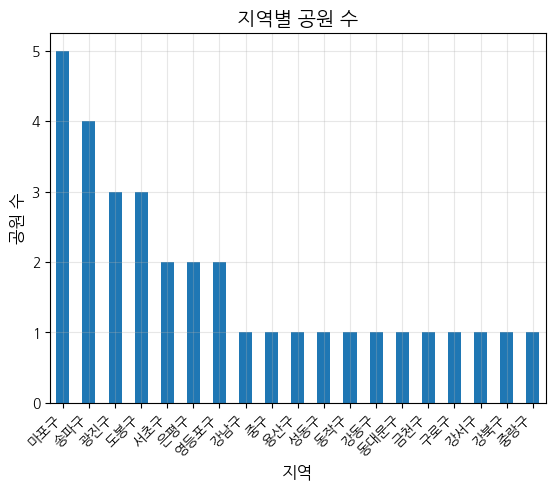

In [26]:
plt.figure(figsize=(12, 6))
merged_data.sort_values(by='park_count', ascending=False).plot.bar(x='region', y='park_count', legend=False)
plt.title("지역별 공원 수", fontsize=14)
plt.xlabel("지역", fontsize=12)
plt.ylabel("공원 수", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.show()


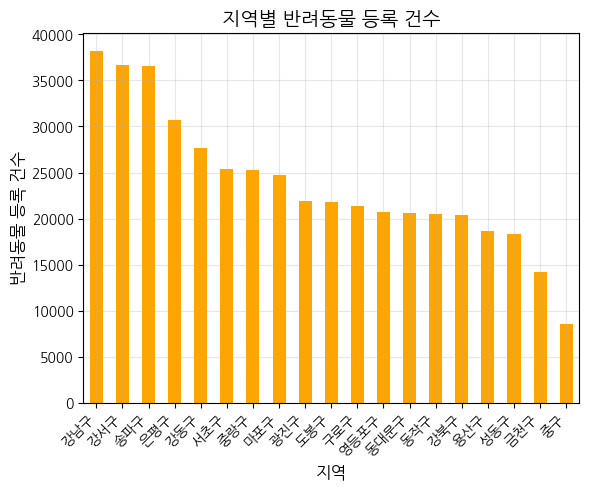

In [27]:
merged_data.sort_values(by='pet_count', ascending=False).plot.bar(x='region', y='pet_count', color='orange', legend=False)
plt.title("지역별 반려동물 등록 건수", fontsize=14)
plt.xlabel("지역", fontsize=12)
plt.ylabel("반려동물 등록 건수", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.show()

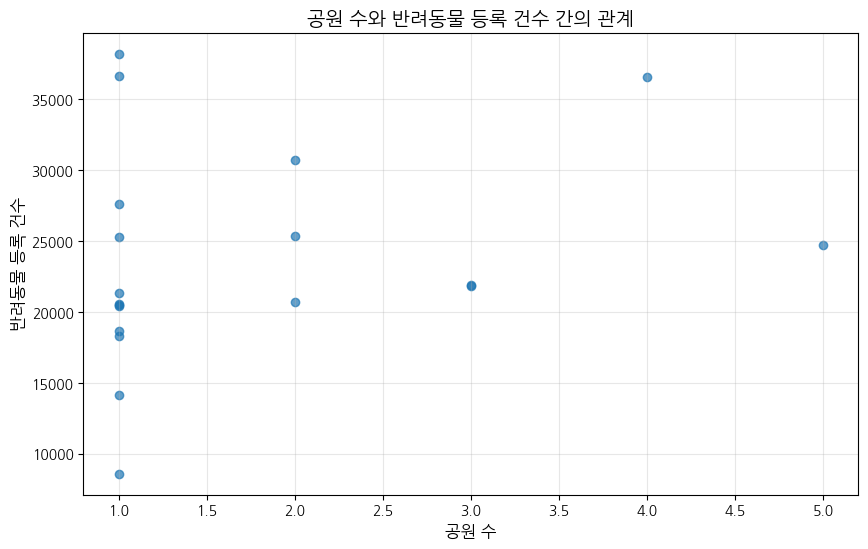

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['park_count'], merged_data['pet_count'], alpha=0.7)
plt.title("공원 수와 반려동물 등록 건수 간의 관계", fontsize=14)
plt.xlabel("공원 수", fontsize=12)
plt.ylabel("반려동물 등록 건수", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


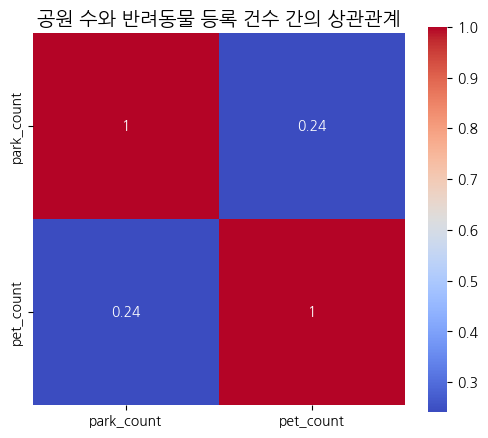

In [29]:
correlation_data = merged_data[['park_count', 'pet_count']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("공원 수와 반려동물 등록 건수 간의 상관관계", fontsize=14)
plt.show()

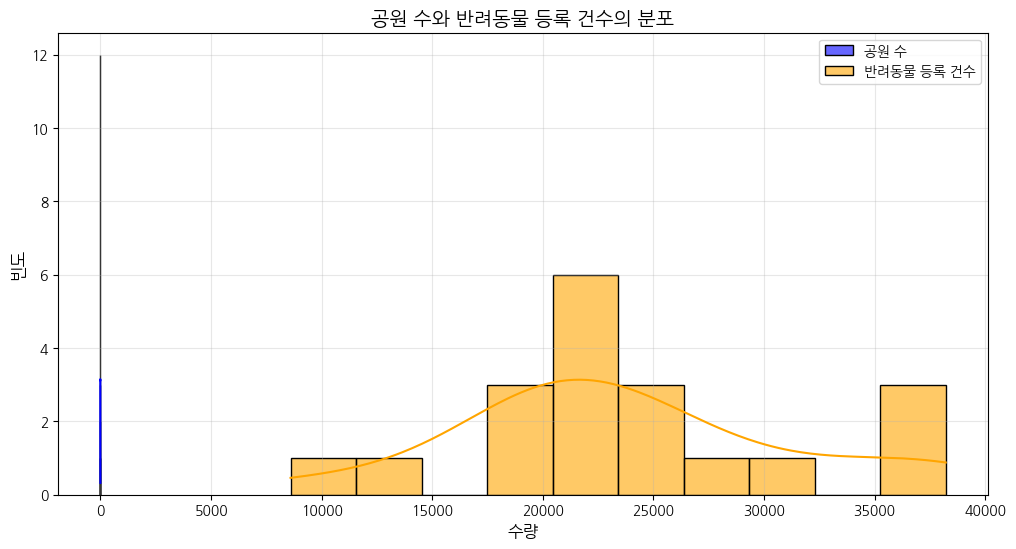

In [30]:
plt.figure(figsize=(12, 6))
sns.histplot(merged_data['park_count'], bins=10, kde=True, color='blue', label='공원 수', alpha=0.6)
sns.histplot(merged_data['pet_count'], bins=10, kde=True, color='orange', label='반려동물 등록 건수', alpha=0.6)
plt.title("공원 수와 반려동물 등록 건수의 분포", fontsize=14)
plt.xlabel("수량", fontsize=12)
plt.ylabel("빈도", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()
